In [6]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os
from dotenv import load_dotenv


In [7]:
# Nama database dan collection
db_name = 'regresiPossionAnalisisSentimenYTRewind'
collection_name = 'preprocessingData2023'

# Memuat value dari file .env
load_dotenv()

mongodb_url = os.getenv('URL_SANDY')
local_url = os.getenv('URL_LOCAL')

# Membuat koneksi ke MongoDB
client = MongoClient(local_url)
db = client[db_name]
collection = db[collection_name]
data = list(collection.find())

In [8]:
# Konversi data menjadi dataframe
df = pd.DataFrame(data)

# Menghitung panjang komentar dalam jumlah kata
df['comment_length'] = df['textOriginal'].apply(lambda x: len(x.split()))

# Menghitung waktu sejak komentar diposting dalam detik
df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.tz_localize(None)
df['time_since_posted'] = (pd.Timestamp.now() - df['publishedAt']).dt.total_seconds()

# Konversi kolom 'is_reply' menjadi numerik jika belum
df['is_reply'] = df['is_reply'].astype(int)

# Menambahkan intercept ke dalam model
df['intercept'] = 1

# Mendefinisikan variabel independen dan dependen
X = df[['intercept', 'likeCount', 'time_since_posted', 'is_reply']]
y = df['comment_length']

# Membangun model regresi Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Prediksi jumlah kata
df['predicted_comment_length'] = poisson_model.predict(X)

## Plot Nilai Aktual vs Nilai Prediksi

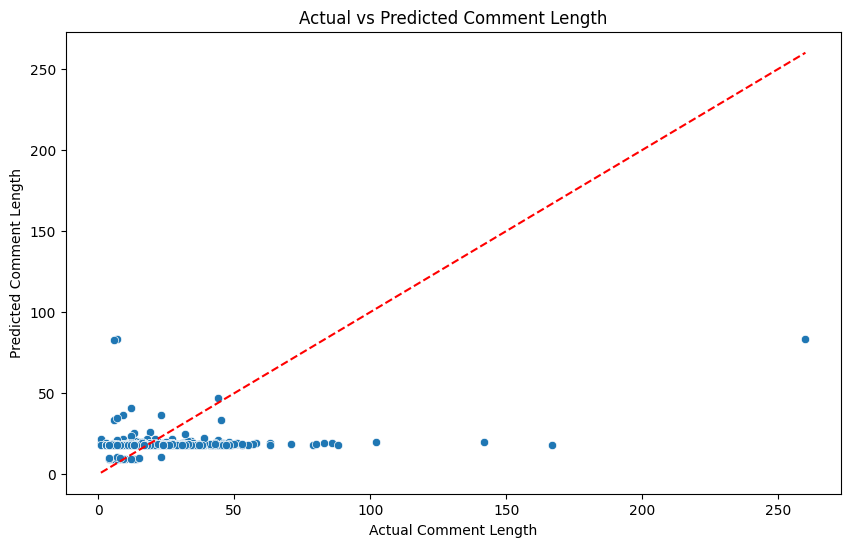

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='comment_length', y='predicted_comment_length', data=df)
plt.xlabel('Actual Comment Length')
plt.ylabel('Predicted Comment Length')
plt.title('Actual vs Predicted Comment Length')
plt.plot([df['comment_length'].min(), df['comment_length'].max()], 
         [df['comment_length'].min(), df['comment_length'].max()], 
         color='red', linestyle='--')
plt.show()


## Plot Residual

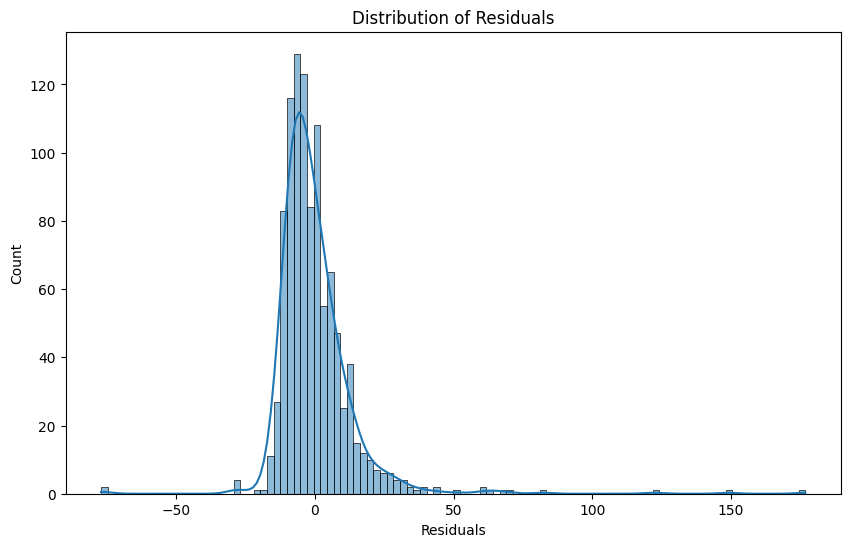

In [10]:
df['residual'] = df['comment_length'] - df['predicted_comment_length']

plt.figure(figsize=(10, 6))
sns.histplot(df['residual'], kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


## Plot Distribusi Panjang Komentar

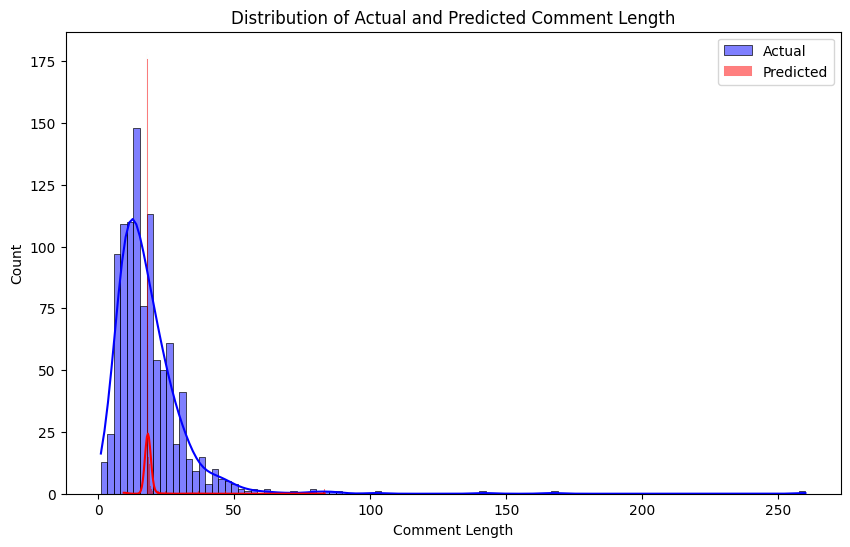

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_length'], kde=True, color='blue', label='Actual')
sns.histplot(df['predicted_comment_length'], kde=True, color='red', label='Predicted')
plt.xlabel('Comment Length')
plt.title('Distribution of Actual and Predicted Comment Length')
plt.legend()
plt.show()
